In [103]:
!pip install datetime
!pip install yfinance
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install scipy

In [104]:
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import norm

In [85]:
# Define ticker symbol and start/end dates
ticker = 'TSLA'
start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

# Download historical data
stock_data = yf.download(ticker, start=start, end=end)

stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500


In [86]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1172 entries, 2020-01-02 to 2024-08-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1172 non-null   float64
 1   High       1172 non-null   float64
 2   Low        1172 non-null   float64
 3   Close      1172 non-null   float64
 4   Adj Close  1172 non-null   float64
 5   Volume     1172 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 64.1 KB


In [87]:
stock_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000,1.172000e+03
mean,207.217064,211.871419,202.242536,207.151006,207.151006,1.282191e+08
std,80.442971,82.052240,78.540455,80.257953,80.257953,8.387299e+07
min,24.980000,26.990667,23.367332,24.081333,24.081333,2.940180e+07
25%,169.274998,174.397495,166.649994,170.149994,170.149994,7.698735e+07
50%,216.698334,221.651665,211.004997,216.510002,216.510002,1.038877e+08
75%,255.752502,260.567505,250.528332,256.499992,256.499992,1.484090e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


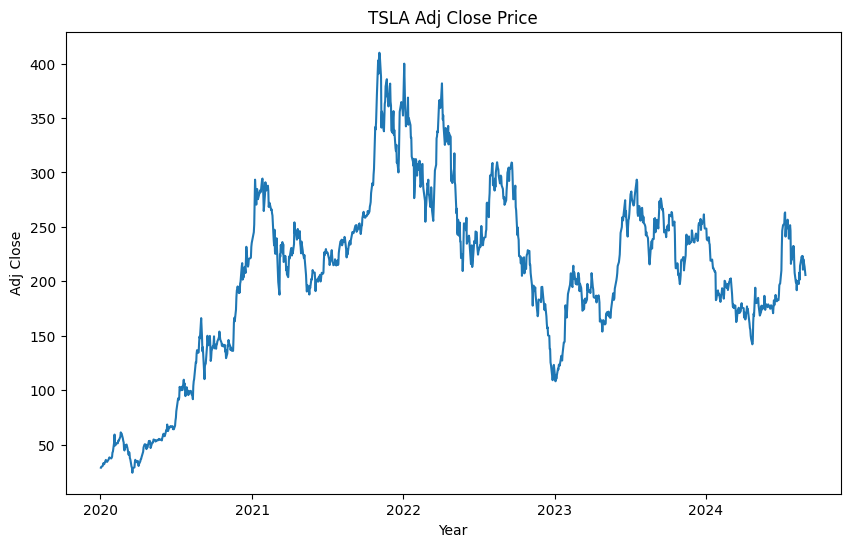

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Adj Close'])
plt.title(f"{ticker} Adj Close Price")
plt.xlabel("Year")
plt.ylabel("Adj Close")
plt.show()

In [89]:
null = stock_data.isnull().sum()
print(null)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [90]:
duplicates = stock_data.duplicated().sum()
print(duplicates)

0


In [91]:
stock_data.to_csv('stock_data.csv')

In [107]:
# Log returns
stock_data['Log Return'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))

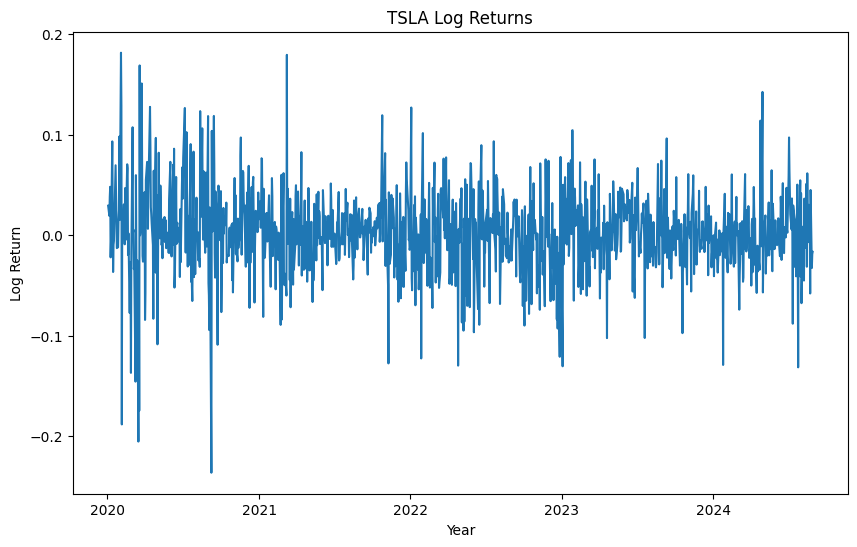

In [108]:
# Plot log returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Log Return'])
plt.title(f"{ticker} Log Returns")
plt.xlabel("Year")
plt.ylabel("Log Return")
plt.show()

In [118]:
# Calculate cumulative log returns
stock_data['Cumulative Log Return'] = stock_data['Log Return'].cumsum()

# Convert cumulative log returns to cumulative returns
stock_data['Cumulative Return'] = np.exp(stock_data['Cumulative Log Return']) - 1

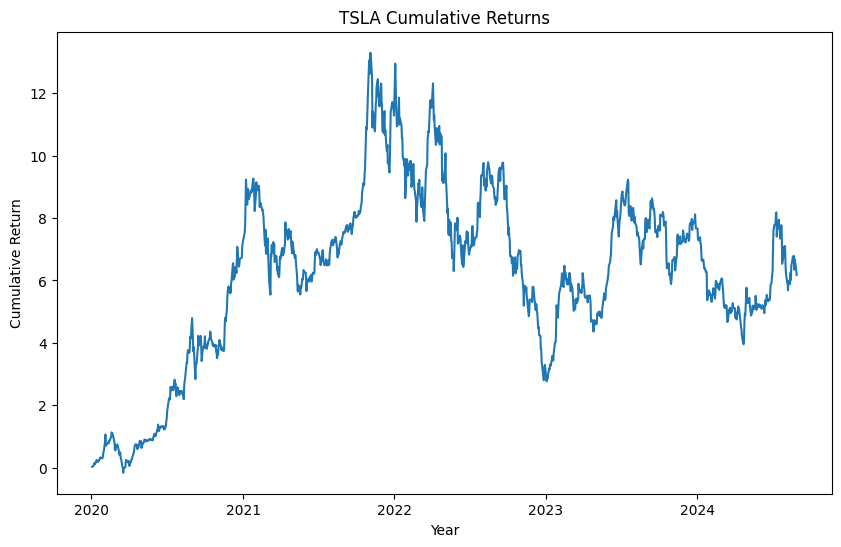

In [119]:
# Plot cumulative log returns
plt.figure(figsize=(10, 6))
plt.plot(stock_data['Cumulative Return'])
plt.title(f"{ticker} Cumulative Returns")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.show()

In [120]:
# Rolling volatility
stock_data['Rolling Volatility'] = stock_data['Log Return'].rolling(window=20).std()

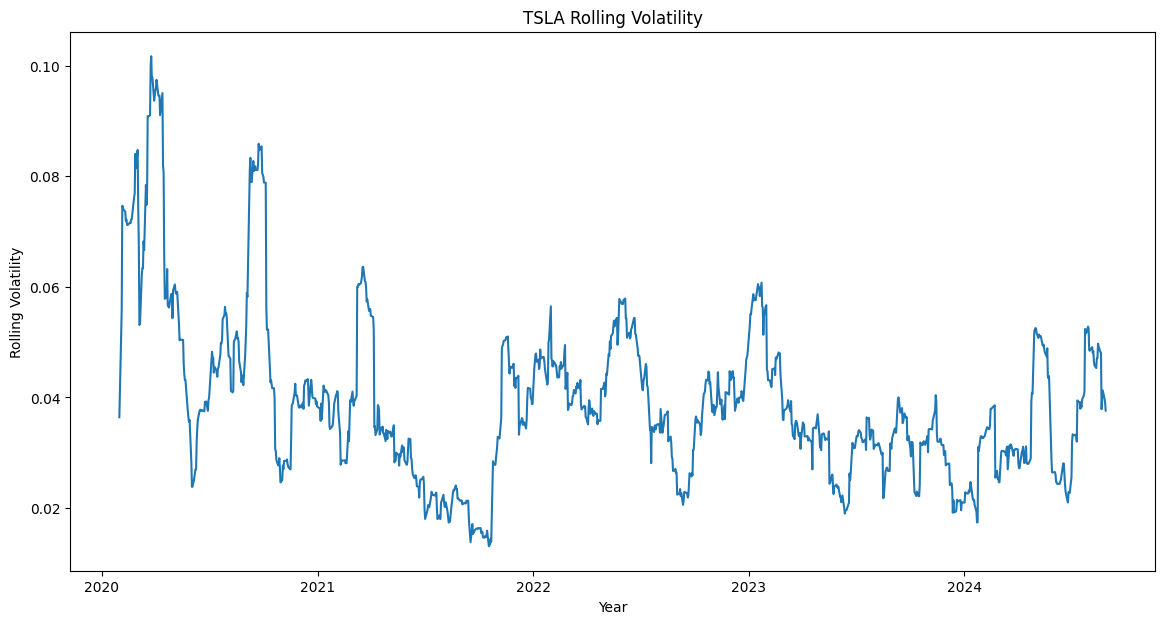

In [121]:
# Plot volatility
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Rolling Volatility'])
plt.title(f"{ticker} Rolling Volatility")
plt.xlabel("Year")
plt.ylabel("Rolling Volatility")
plt.show()

In [67]:
# Calculate simple moving average (SMA)
def SMA(data, window):
    return data['Adj Close'].rolling(window=window).mean()

# 50-day SMA
stock_data['50-Day SMA'] = SMA(stock_data, window=50)

# 200-day SMA
stock_data['200-Day SMA'] = SMA(stock_data, window=200)

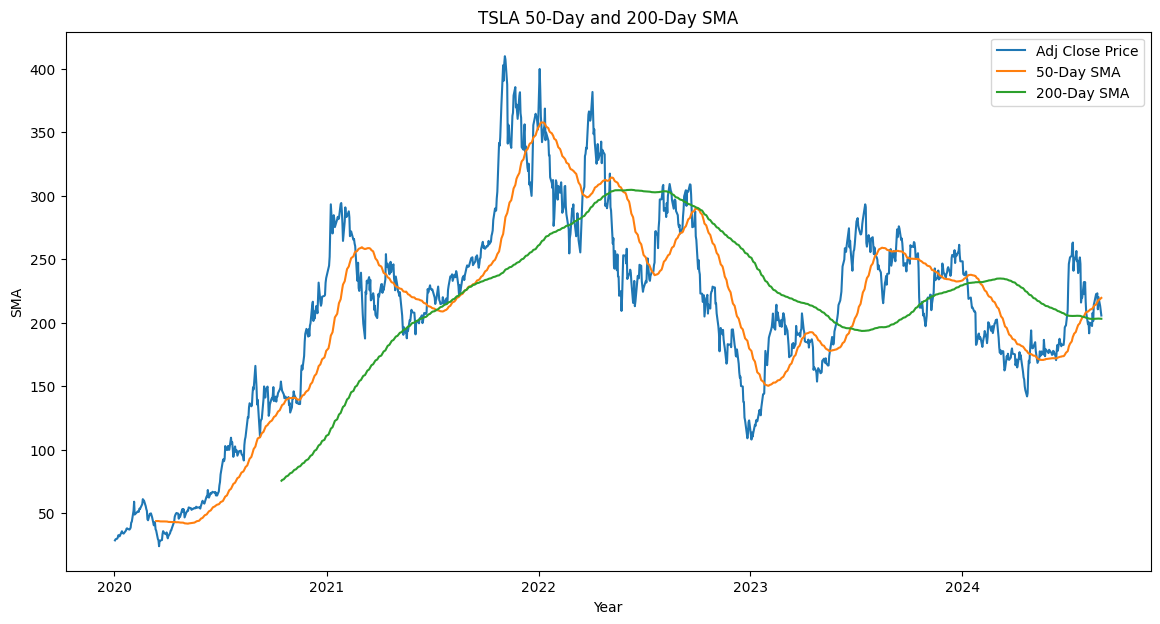

In [68]:
# Plot SMA
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'], label = "Adj Close Price")
plt.plot(stock_data['50-Day SMA'], label="50-Day SMA")
plt.plot(stock_data['200-Day SMA'], label="200-Day SMA")
plt.title(f"{ticker} 50-Day and 200-Day SMA")
plt.xlabel("Year")
plt.ylabel("SMA")
plt.legend()
plt.show()

In [69]:
# Identifying golden crosses
golden_cross = stock_data[(stock_data['50-Day SMA'] > stock_data['200-Day SMA']) & (stock_data['50-Day SMA'].shift(1) <=stock_data['200-Day SMA'].shift(1))]

# Identifying death crosses
death_cross = stock_data[(stock_data['50-Day SMA'] < stock_data['200-Day SMA']) & (stock_data['50-Day SMA'].shift(1) >=stock_data['200-Day SMA'].shift(1))]

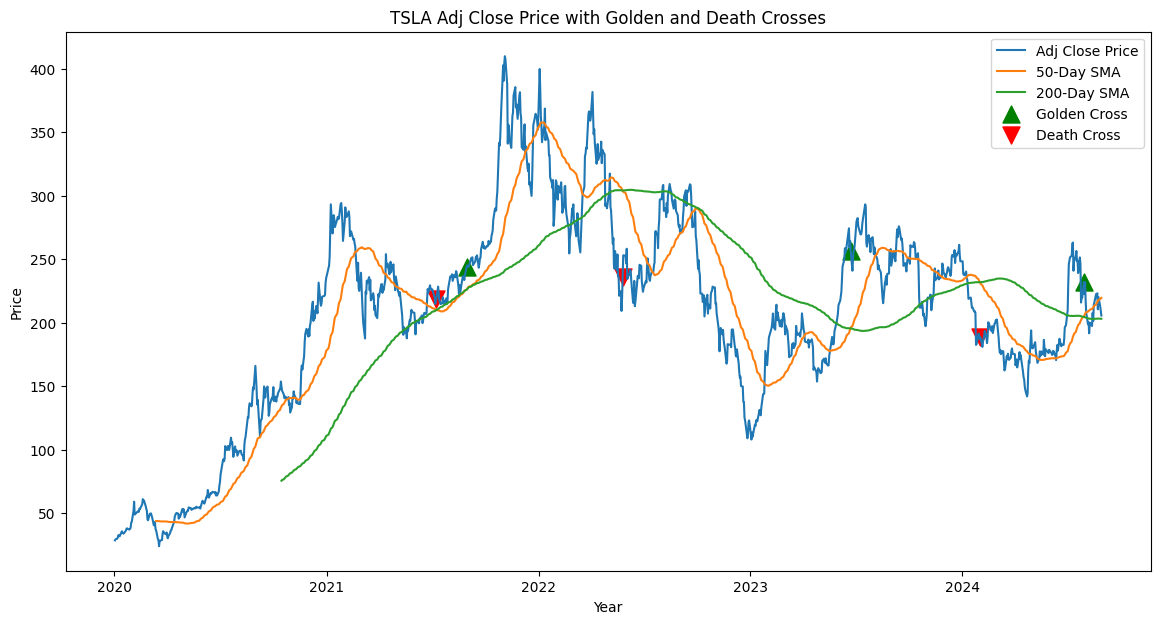

In [70]:
# Plot with markers
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Adj Close'], label = "Adj Close Price")
plt.plot(stock_data['50-Day SMA'], label="50-Day SMA")
plt.plot(stock_data['200-Day SMA'], label="200-Day SMA")

# Plot golden crosses
plt.scatter(golden_cross.index, stock_data.loc[golden_cross.index, 'Adj Close'], marker='^', color='green', s=150, label='Golden Cross')

# Plot death crosses
plt.scatter(death_cross.index, stock_data.loc[death_cross.index, 'Adj Close'], marker='v', color='red', s=150, label='Death Cross')

plt.title(f"{ticker} Adj Close Price with Golden and Death Crosses")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.show()

In [71]:
# Calculate relative strength index (RSI)
def RSI(data, window=14):
    change = data['Adj Close'].diff()
    gain = change.where(change > 0, 0)
    loss = -change.where(change < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100 / (1 + RS))
    
    return RSI

stock_data['RSI'] = RSI(stock_data)

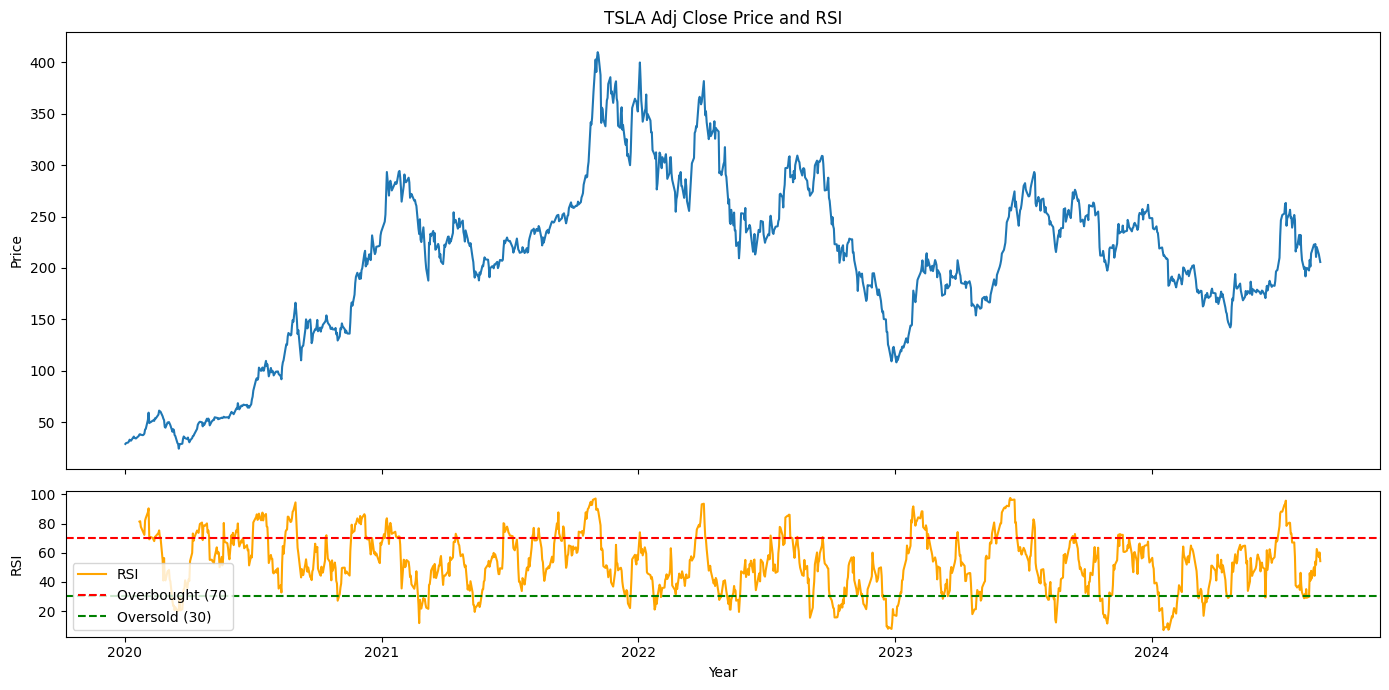

In [72]:
# Plot RSI

# Create a figure with two subplots: one for adj close price and one for RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the adj close price on the first (larger) subplot
ax1.plot(stock_data['Adj Close'])
ax1.set_title(f"{ticker} Adj Close Price and RSI")
ax1.set_ylabel("Price")

# Plot RSI on the second (smaller) subplot
ax2.plot(stock_data['RSI'], label="RSI", color='orange')
ax2.axhline(70, color='red', linestyle='--', label="Overbought (70")
ax2.axhline(30, color='green', linestyle='--', label="Oversold (30)")
ax2.set_xlabel("Year")
ax2.set_ylabel("RSI")
ax2.legend()

# Improve layout
plt.tight_layout()

plt.show()

In [73]:
# Calculate bollinger bands
def bollinger_bands(data, window=20):
    middle_band = data['Adj Close'].rolling(window=window).mean()
    upper_band = middle_band + 2 * data['Adj Close'].rolling(window=window).std()
    lower_band = middle_band - 2 * data['Adj Close'].rolling(window=window).std()
    
    return middle_band, upper_band, lower_band

stock_data['Middle Band'], stock_data['Upper Band'], stock_data['Lower Band'] = bollinger_bands(stock_data)

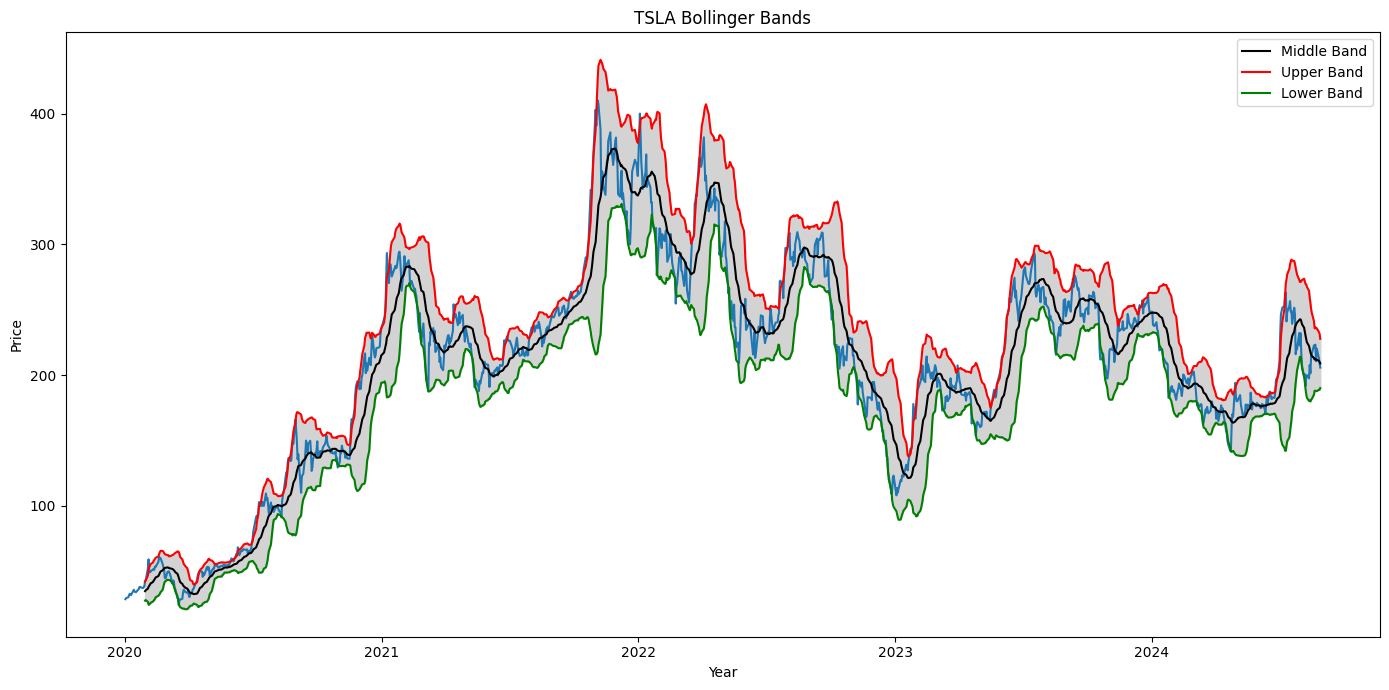

In [74]:
# Plot bollinger bands with price
plt.figure(figsize=(14, 7))

# Plot adj close price
plt.plot(stock_data['Adj Close'])

# Plot bollinger bands
plt.plot(stock_data['Middle Band'], label='Middle Band', color='black')
plt.plot(stock_data['Upper Band'], label='Upper Band', color='red')
plt.plot(stock_data['Lower Band'], label='Lower Band', color='green')

# Fill area between bands
plt.fill_between(stock_data.index, stock_data['Lower Band'], stock_data['Upper Band'], color='lightgray')

plt.title(f"{ticker} Bollinger Bands")
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()

# Improve layout
plt.tight_layout()

plt.show()

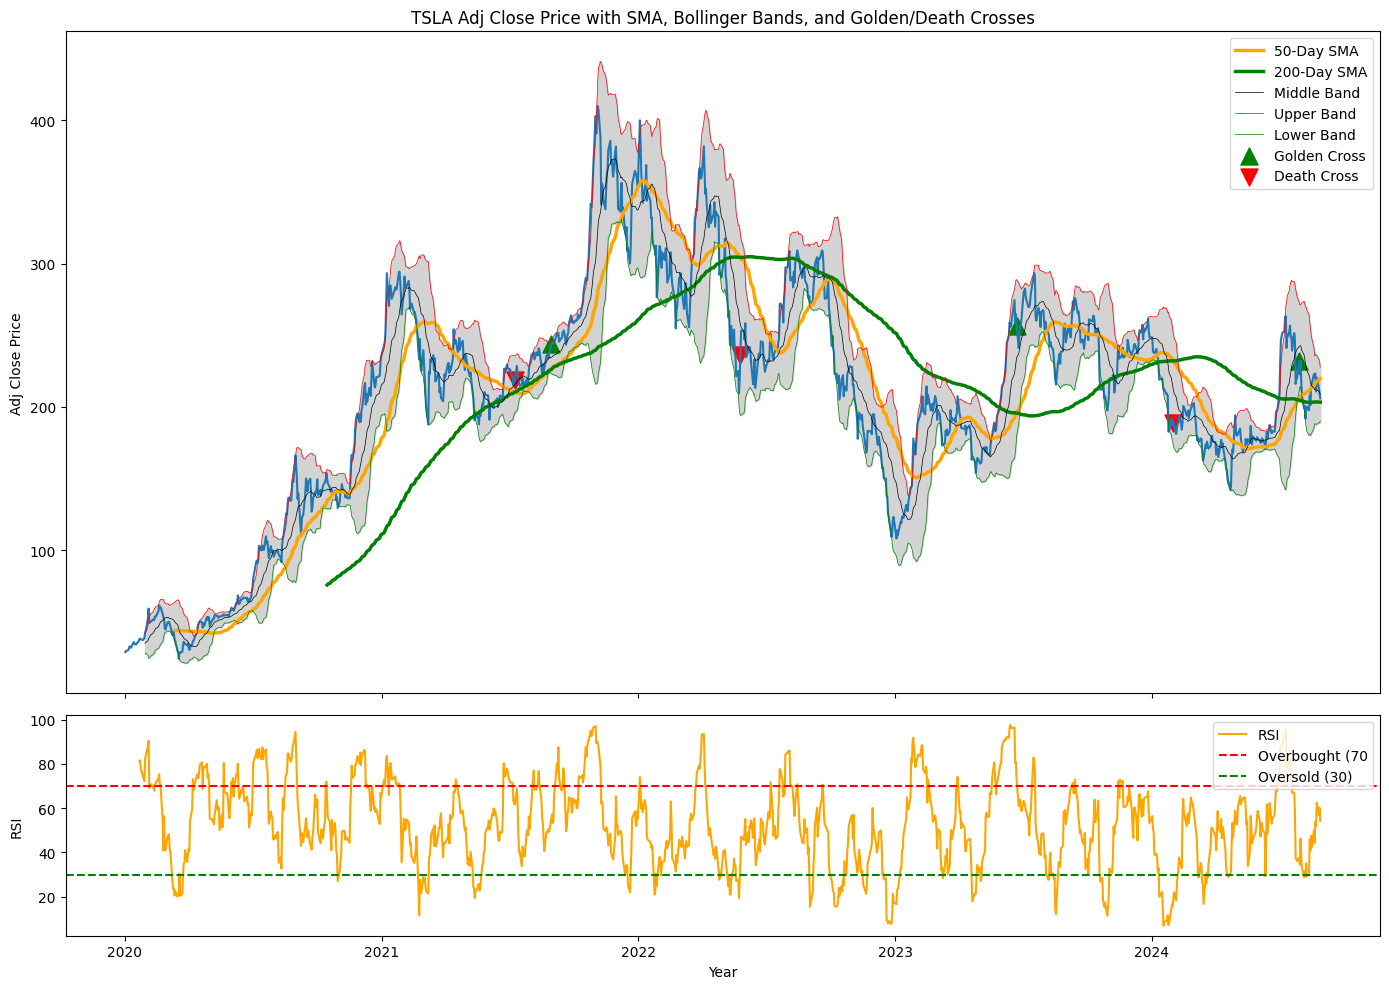

In [75]:
# Comprehensive plot: golden and death crosses, 50-Day and 200-Day SMA, bollinger bands, and RSI

# Create a figure with two subplots: one for adj close price and moving averages, and one for RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot the adj close price on the first (larger) subplot
ax1.plot(stock_data['Adj Close'])

# Plot the 50-Day and 200-Day SMA
ax1.plot(stock_data['50-Day SMA'], label='50-Day SMA', color='orange', lw=2.5)
ax1.plot(stock_data['200-Day SMA'], label='200-Day SMA', color='green', lw=2.5)
# Plot bollinger bands
ax1.plot(stock_data['Middle Band'], label='Middle Band', color='black', lw=0.5)
ax1.plot(stock_data['Upper Band'], label='Upper Band', color='red', lw=0.5)
ax1.plot(stock_data['Lower Band'], label='Lower Band', color='green', lw=0.5)

# Fill area between bands
ax1.fill_between(stock_data.index, stock_data['Lower Band'], stock_data['Upper Band'], color='lightgray')

# Plot golden crosses
ax1.scatter(golden_cross.index, stock_data.loc[golden_cross.index, 'Adj Close'], marker='^', color='green', s=150, label='Golden Cross')

# Plot death crosses
ax1.scatter(death_cross.index, stock_data.loc[death_cross.index, 'Adj Close'], marker='v', color='red', s=150, label='Death Cross')

# Set title and labels for first subplot
ax1.set_title(f"{ticker} Adj Close Price with SMA, Bollinger Bands, and Golden/Death Crosses")
ax1.set_ylabel("Adj Close Price")
ax1.legend()

# Plot RSI on the second (smaller) subplot
ax2.plot(stock_data['RSI'], label="RSI", color='orange')
ax2.axhline(70, color='red', linestyle='--', label="Overbought (70")
ax2.axhline(30, color='green', linestyle='--', label="Oversold (30)")
ax2.set_xlabel("Year")
ax2.set_ylabel("RSI")
ax2.legend()

# Improve layout
plt.tight_layout()

plt.show()